In [1]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pickle
import numpy as np
np.random.seed(42)

from keras.callbacks import Callback, EarlyStopping
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, SpatialDropout1D
from keras.layers import LSTM, SimpleRNN, GRU
from keras.regularizers import l2
from keras.constraints import maxnorm
from keras.datasets import imdb

from qrnn.qrnn import QRNN

Using TensorFlow backend.


# Preparing datas

In [3]:
max_features = 20000
maxlen = 256
batch_size = 32
epochs = 1
padding_mode = "pre"
truncating_mode = "pre"

In [4]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print("Original Data - Unknown length")
print("X_train shape :", X_train.shape)
print("X_test shape :", X_test.shape)

print("Padding")
X_train = sequence.pad_sequences(X_train, maxlen=maxlen,  padding=padding_mode, truncating=truncating_mode)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen,  padding=padding_mode, truncating=truncating_mode)

print("Prepared Data - Knowns length")
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

25000 train sequences
25000 test sequences
Original Data - Unknown length
X_train shape : (25000,)
X_test shape : (25000,)
Padding
Prepared Data - Knowns length
X_train shape: (25000, 256)
X_test shape: (25000, 256)


In [22]:
X_train[:32,:]

array([[  37,    9, 1861, ...,    4,  392,  555],
       [   0,    0,    0, ...,  194,  194,  164],
       [   0,    0,    0, ...,    5,   55,  441],
       ..., 
       [   0,    0,    0, ...,   46,   23,  288],
       [   0,    0,    0, ...,  378,    7,  211],
       [  29,  266,  638, ...,   14, 1458, 1253]])

Le dataset est donc actuellement de 256 timesteps et 1 seul input size. Un layer de Embedding va augmenter la taille du input à 128 dimensions. On peut regarder sa sortie en utilisant le code suivant

In [21]:
from keras.models import Model

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(SimpleRNN(128))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
#                      validation_data=(X_test, y_test),
#                      verbose=0)


submodel = Model(inputs=model.input,
                          outputs=model.layers[0].output)

print(submodel.predict(X_train[:32, :]).shape)

(32, 256, 128)


En sortie du layer de Embedding on a donc un batch de 32 x 256 timesteps : 128 inputs size. On va aussi regarder la balance du dataset

In [4]:
print(np.bincount(y_train))
print(np.bincount(y_test))

[12500 12500]
[12500 12500]


On a dans les 2 cas un dataset parfaitement équilibré. La prédiction naive serait donc à 50 %

# Training Models

Le training sur ce dataset a très vite tendance à overfitter. En 1 à 2 Epoch, le modèle est entrainé. Du coup, afin de pouvoir visualiser le training, on va récuperer le loss et l'accuracy par batch et le loss et l'accuracy sur le test set en fin d'Epoch. Au passage on va aussi enregistrer le temps mis par batch.

In [6]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.epoch_time_start = time.time()
        self.times = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
#     def on_epoch_begin(self, batch, logs={}):
#         self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
    
    def on_batch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        self.losses.append(logs.get('loss'))
#         self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
#         self.val_acc.append(logs.get('val_acc'))
        
    def convert_to_dict(self):
        return {
            "time" : self.times,
            "acc" : self.acc,
            "val_acc" : self.val_acc,
            "loss" : self.losses,
            "val_loss" : self.val_losses
        }
    
time_callback = TimeHistory()

# early = EarlyStopping(
#             monitor='loss',
#             min_delta=0,
#             patience=3,
#             verbose=1,
#             mode='auto')

Maintenant on peut tester nos Modèles.

# Simple RNN

In [7]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(SimpleRNN(128))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                     validation_data=(X_test, y_test),
                     verbose=0, callbacks=[time_callback])

with open('srnn', 'wb') as file:
    pickle.dump(time_callback.convert_to_dict(), file)

KeyboardInterrupt: 

# LSTM

In [8]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                     validation_data=(X_test, y_test),
                     verbose=0, callbacks=[time_callback])

with open('lstm', 'wb') as file:
    pickle.dump(time_callback.convert_to_dict(), file)

# GRU

In [9]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(GRU(128))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history3 = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                     validation_data=(X_test, y_test),
                     verbose=0, callbacks=[time_callback])

with open('gru', 'wb') as file:
    pickle.dump(time_callback.convert_to_dict(), file)

# QRNN

In [46]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(QRNN(128, window_size=5))
# dropout=0.2, kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4), kernel_constraint=maxnorm(10), bias_constraint=maxnorm(10)
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history4 = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                     validation_data=(X_test, y_test),
                     verbose=0, callbacks=[time_callback])

with open('qrnn2', 'wb') as file:
    pickle.dump(time_callback.convert_to_dict(), file)

# Resultats

Durant le training, on a récupéré les temps d'entrainement/loss et accuracy. Comme c'est fait par batch, les données sont très bruitées. Du coup, on va lisser la courbe

In [26]:
def lissage(Lx, Ly, p):
    '''Fonction qui débruite une courbe par une moyenne glissante
    sur 2P+1 points'''
    Lxout=[]
    Lyout=[]
    Lxout = Lx[p: -p]
    for index in range(p, len(Ly)-p):
        average = sum(Ly[index-p : index+p+1]) / (2*p + 1)
        Lyout.append(average)

    return Lxout,Lyout


In [23]:
with open('srnn', 'rb') as f:
    srnn_stat = pickle.load(f)
    
with open('lstm', 'rb') as f:
    lstm_stat = pickle.load(f)
    
with open('gru', 'rb') as f:
    gru_stat = pickle.load(f)
    
with open('qrnn2', 'rb') as f:
    qrnn_stat = pickle.load(f)

On n'a pas dans notre history, l'etat a 0 batch. De ce fait on va l'ajouter. On sait que le dataset est balance, du coup sur 25000 tests, on peut imaginer que l'on s'est trompé 50 % du temps. L'accuracy est donc à 50%. Pour le Loss, il vaut donc -1*log(0.5)-(1-0)*log(1-0.5)) = 0.602.

In [24]:
for dico in [srnn_stat, lstm_stat, gru_stat, qrnn_stat]:
    dico["acc"].insert(0, 0.5)
    dico["loss"].insert(0, 0.602)
    dico["time"].insert(0, 0)
    dico["val_acc"].insert(0, 0.5)
    dico["val_loss"].insert(0, 0.602)

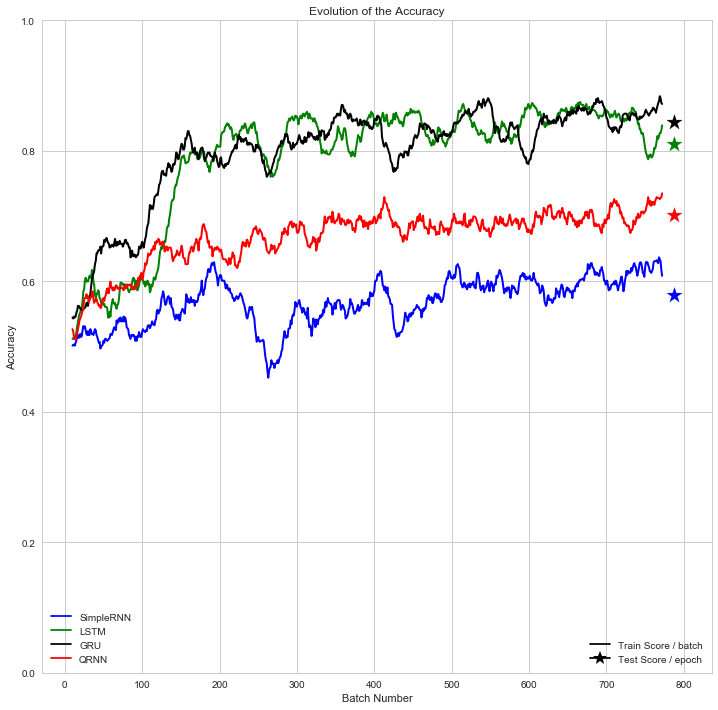

In [34]:
lissage_size = 10
thk = 2

plt.figure(figsize=(12,12))

x = list(range(len(srnn_stat["acc"])))
y = srnn_stat["acc"]
x1, y1 = lissage(x, y, lissage_size)
plt.plot(x1, y1, "b", linewidth=thk)
plt.scatter(max(x)+5, srnn_stat["val_acc"][-1], c="b", marker = "*", s=250)

x = list(range(len(lstm_stat["acc"])))
y = lstm_stat["acc"]
x1, y1 = lissage(x, y, lissage_size)
plt.plot(x1, y1, "g", linewidth=thk)
plt.scatter(max(x)+5, lstm_stat["val_acc"][-1], c="g", marker = "*", s=250)


x = list(range(len(gru_stat["acc"])))
y = gru_stat["acc"]
x1, y1 = lissage(x, y, lissage_size)
plt.plot(x1, y1, "k", linewidth=thk)
plt.scatter(max(x)+5, gru_stat["val_acc"][-1], c="k", marker = "*", s=250)

x = list(range(len(qrnn_stat["acc"])))
y = qrnn_stat["acc"]
x1, y1 = lissage(x, y, lissage_size)
plt.plot(x1, y1, "r", linewidth=thk)
plt.scatter(max(x)+5, qrnn_stat["val_acc"][-1], c="r", marker = "*", s=250)

blue_line = mlines.Line2D([], [], color='b', markersize=15, label='SimpleRNN')
green_line = mlines.Line2D([], [], color='g', markersize=15, label='LSTM')
black_line = mlines.Line2D([], [], color='k', markersize=15, label='GRU')
red_line = mlines.Line2D([], [], color='r', markersize=15, label='QRNN')
train_line = mlines.Line2D([], [], color='k', markersize=15, label='Train Score / batch')
test_line = mlines.Line2D([], [], color='k', marker='*', markersize=15, label='Test Score / epoch')

first_legend = plt.legend(handles=[blue_line, green_line, black_line, red_line], loc=3)
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[train_line, test_line], loc=4)
plt.title("Evolution of the Accuracy")
plt.xlabel("Batch Number")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.savefig("img/acc_batch.png")
plt.show()

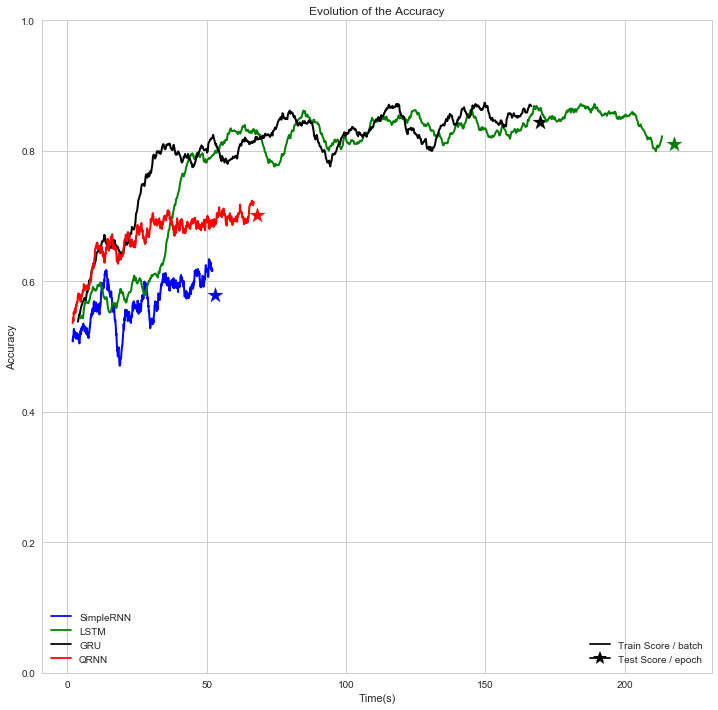

In [33]:
lissage_size = 15
thk = 2

plt.figure(figsize=(12,12))

x = srnn_stat["time"]
y = srnn_stat["acc"]
x1, y1 = lissage(x, y, lissage_size)
plt.plot(x1, y1, "b", linewidth=thk)
plt.scatter(max(x), srnn_stat["val_acc"][-1], c="b", marker = "*", s=250)


x = lstm_stat["time"]
y = lstm_stat["acc"]
x1, y1 = lissage(x, y, lissage_size)
plt.plot(x1, y1, "g", linewidth=thk)
plt.scatter(max(x), lstm_stat["val_acc"][-1], c="g", marker = "*", s=250)


x = gru_stat["time"]
y = gru_stat["acc"]
x1, y1 = lissage(x, y, lissage_size)
plt.plot(x1, y1, "k", linewidth=thk)
plt.scatter(max(x), gru_stat["val_acc"][-1], c="k", marker = "*", s=250)


x = qrnn_stat["time"]
y = qrnn_stat["acc"]
x1, y1 = lissage(x, y, lissage_size)
plt.plot(x1, y1, "r", linewidth=thk)
plt.scatter(max(x), qrnn_stat["val_acc"][-1], c="r", marker = "*", s=250)


blue_line = mlines.Line2D([], [], color='b', markersize=15, label='SimpleRNN')
green_line = mlines.Line2D([], [], color='g', markersize=15, label='LSTM')
black_line = mlines.Line2D([], [], color='k', markersize=15, label='GRU')
red_line = mlines.Line2D([], [], color='r', markersize=15, label='QRNN')
train_line = mlines.Line2D([], [], color='k', markersize=15, label='Train Score / batch')
test_line = mlines.Line2D([], [], color='k', marker='*', markersize=15, label='Test Score / epoch')

first_legend = plt.legend(handles=[blue_line, green_line, black_line, red_line], loc=3)
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[train_line, test_line], loc=4)
plt.title("Evolution of the Accuracy")
plt.xlabel("Time(s)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.savefig("img/acc_time.png")
plt.show()

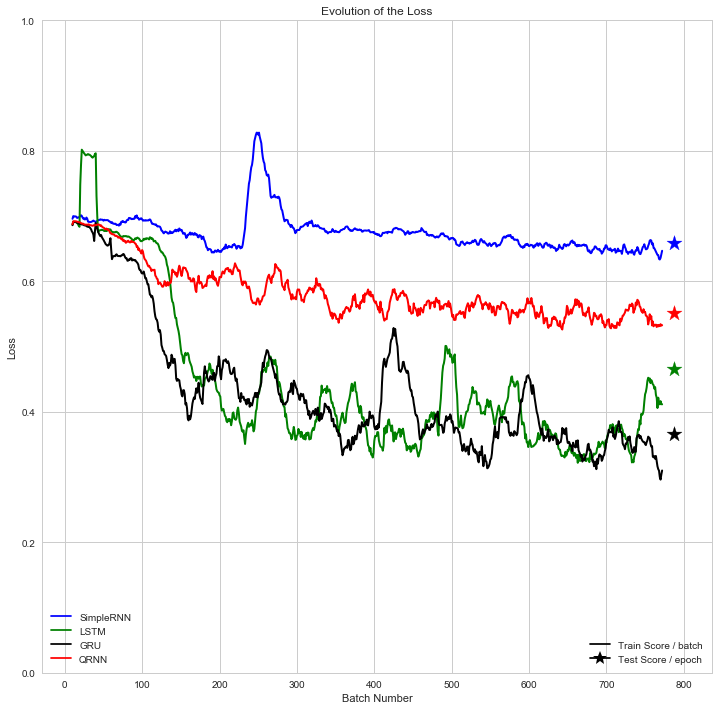

In [32]:
lissage_size = 10
thk = 2

plt.figure(figsize=(12,12))

x = list(range(len(srnn_stat["loss"])))
y = srnn_stat["loss"]
x1, y1 = lissage(x, y, lissage_size)
plt.plot(x1, y1, "b", linewidth=thk)
plt.scatter(max(x)+5, srnn_stat["val_loss"][-1], c="b", marker = "*", s=250)

x = list(range(len(lstm_stat["loss"])))
y = lstm_stat["loss"]
x1, y1 = lissage(x, y, lissage_size)
plt.plot(x1, y1, "g", linewidth=thk)
plt.scatter(max(x)+5, lstm_stat["val_loss"][-1], c="g", marker = "*", s=250)


x = list(range(len(gru_stat["loss"])))
y = gru_stat["loss"]
x1, y1 = lissage(x, y, lissage_size)
plt.plot(x1, y1, "k", linewidth=thk)
plt.scatter(max(x)+5, gru_stat["val_loss"][-1], c="k", marker = "*", s=250)

x = list(range(len(qrnn_stat["loss"])))
y = qrnn_stat["loss"]
x1, y1 = lissage(x, y, lissage_size)
plt.plot(x1, y1, "r", linewidth=thk)
plt.scatter(max(x)+5, qrnn_stat["val_loss"][-1], c="r", marker = "*", s=250)

blue_line = mlines.Line2D([], [], color='b', markersize=15, label='SimpleRNN')
green_line = mlines.Line2D([], [], color='g', markersize=15, label='LSTM')
black_line = mlines.Line2D([], [], color='k', markersize=15, label='GRU')
red_line = mlines.Line2D([], [], color='r', markersize=15, label='QRNN')
train_line = mlines.Line2D([], [], color='k', markersize=15, label='Train Score / batch')
test_line = mlines.Line2D([], [], color='k', marker='*', markersize=15, label='Test Score / epoch')

first_legend = plt.legend(handles=[blue_line, green_line, black_line, red_line], loc=3)
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[train_line, test_line], loc=4)
plt.title("Evolution of the Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.ylim(0,1)
plt.savefig("img/loss_batch.png")
plt.show()

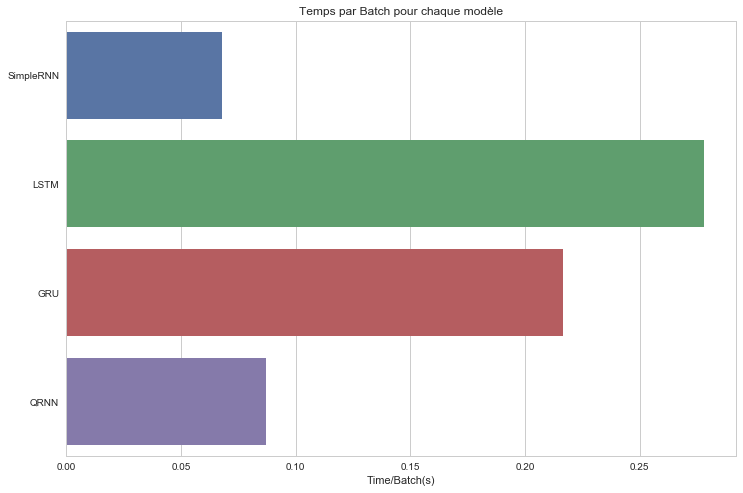

In [31]:
TSRNN = max(srnn_stat["time"])/len(srnn_stat["time"])
TLSTM = max(lstm_stat["time"])/len(lstm_stat["time"])
TGRU = max(gru_stat["time"])/len(gru_stat["time"])
TQRNN = max(qrnn_stat["time"])/len(qrnn_stat["time"])

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(12, 8))
g = sns.barplot(x=[TSRNN, TLSTM, TGRU, TQRNN] , y=["SimpleRNN","LSTM", "GRU", "QRNN"])

ax.set(ylabel="", xlabel="Time/Batch(s)")
plt.title("Temps par Batch pour chaque modèle")
plt.savefig("img/barplot.png")
plt.show()

# Comparaison Performances

In [12]:
def regenerate_dataset(timesteps=256):
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

    X_train = sequence.pad_sequences(X_train, maxlen=timesteps,  padding=padding_mode, truncating=truncating_mode)
    X_test = sequence.pad_sequences(X_test, maxlen=timesteps,  padding=padding_mode, truncating=truncating_mode)
    X_train, y_train, X_test, y_test = X_train[::2], y_train[::2], X_test[::2], y_test[::2]
    return X_train, y_train, X_test, y_test

In [11]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = 0
        
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times = time.time() - self.epoch_time_start
        
time_callback = TimeHistory()

In [14]:
def time_lstm(batch_size, train_set, test_set):
    model_lstm = Sequential()
    model_lstm.add(Embedding(max_features, 128))
    model_lstm.add(LSTM(128))
    model_lstm.add(Dense(1))
    model_lstm.add(Activation('sigmoid'))

    model_lstm.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model_lstm.fit(*train_set, batch_size=batch_size, epochs=1,
                         validation_data=train_set,
                         verbose=0, callbacks=[time_callback])
    
    return time_callback.times

In [19]:
def time_qrnn(batch_size, train_set, test_set):
    model_qrnn = Sequential()
    model_qrnn.add(Embedding(max_features, 128))
    model_qrnn.add(QRNN(128, window_size=5))
    model_qrnn.add(Dense(1))
    model_qrnn.add(Activation('sigmoid'))

    model_qrnn.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model_qrnn.fit(*train_set, batch_size=batch_size, epochs=1,
                         validation_data=train_set,
                         verbose=0, callbacks=[time_callback])
    
    return time_callback.times

In [ ]:
matrice_results = []
for sequence_length in [32, 64, 128, 256, 512]:
    X_train, y_train, X_test, y_test = regenerate_dataset(sequence_length)
    batch_matrice = []
    for batch_size in [8, 16, 32, 64, 128, 256]:
        t1 = time_qrnn(batch_size=batch_size, train_set=(X_train, y_train), test_set=(X_test, y_test))
        t2 = time_lstm(batch_size=batch_size, train_set=(X_train, y_train), test_set=(X_test, y_test))
        batch_matrice.append(t2/t1)
    matrice_results.append(batch_matrice)

with open('perf', 'wb') as file:
    pickle.dump(matrice_results, file)

In [3]:
# A cause d'un plantage

# matrice_results = [
#     [2.388, 2.397, 3.616, 2.230, 1.819, 1.561],
#     [2.765, 2.612, 2.844, 2.347, 2.187, 1.782],
#     [2.810, 2.820, 2.998, 2.547, 2.160, 1.884],
#     [2.959, 2.862, 3.202, 2.696, 2.414, 1.952],
#     [2.910, 2.853, 3.153, 2.749, 3.373, 2.091]
# ]

# with open('perf', 'wb') as file:
#     pickle.dump(matrice_results, file)

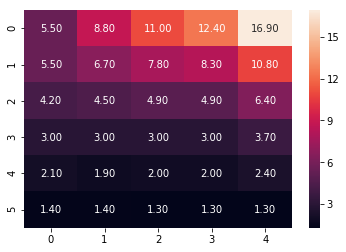

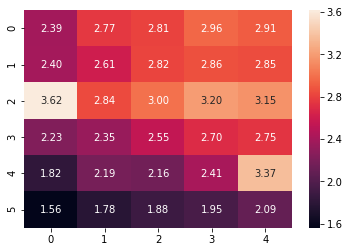

In [4]:
with open('perf', 'rb') as f:
    perfs = pickle.load(f)

perfs = np.array(perfs).T

perf_announced = np.array([
    [5.5, 8.8, 11,  12.4, 16.9],
    [5.5, 6.7, 7.8, 8.3,  10.8],
    [4.2, 4.5, 4.9, 4.9,  6.4 ],
    [3,   3,   3,   3,    3.7 ],
    [2.1, 1.9, 2,   2,    2.4 ],
    [1.4, 1.4, 1.3, 1.3,  1.3 ]
])

sns.heatmap(perf_announced, annot=True, fmt=".2f")
plt.show()
sns.heatmap(perfs, annot=True, fmt=".2f")
plt.show()

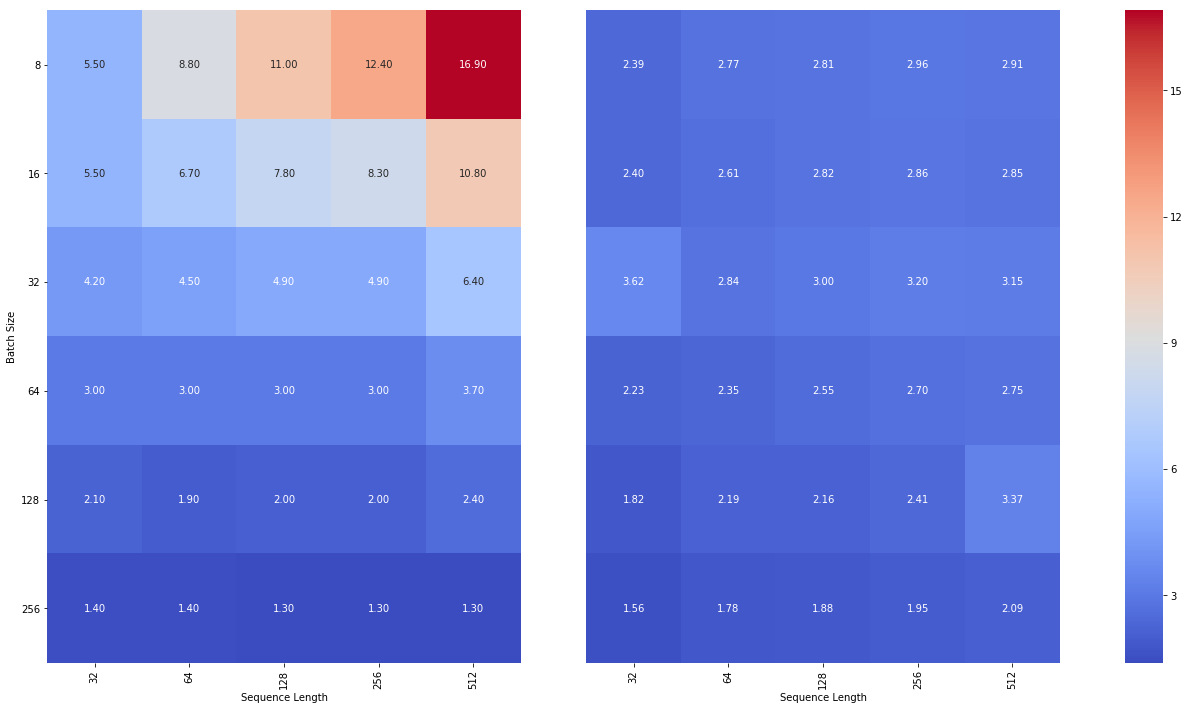

In [32]:
f,(ax1,ax2, axcb) = plt.subplots(1, 3, gridspec_kw={'width_ratios':[1, 1 ,0.08]}, figsize=(20,12))
ax1.get_shared_y_axes().join(ax1,ax2)
g1 = sns.heatmap(perf_announced, 
                 cmap="coolwarm", 
                 cbar=False, 
                 ax=ax1, 
                 annot=True, 
                 fmt=".2f",
                 xticklabels = [32, 64, 128, 256, 512],
                 yticklabels = [8, 16, 32, 64, 128, 256]
                )
g1.set_ylabel('Batch Size')
g1.set_xlabel('Sequence Length')
g2.set_xticks([])
g2.set_yticks([])

g2 = sns.heatmap(perfs, cmap="coolwarm", 
                 cbar_ax=axcb, 
                 vmin=1.4, 
                 vmax=16.9, 
                 ax=ax2, 
                 annot=True, 
                 fmt=".2f", 
                 xticklabels = [32, 64, 128, 256, 512],
                 yticklabels = []
                )

# g2.set_ylabel('Batch Size')
g2.set_xlabel('Sequence Length')

# may be needed to rotate the ticklabels correctly:
for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

# plt.title("Comparaison des performances annoncées et mesurées")
plt.savefig("img/heatmap_perfs.png")
plt.show()